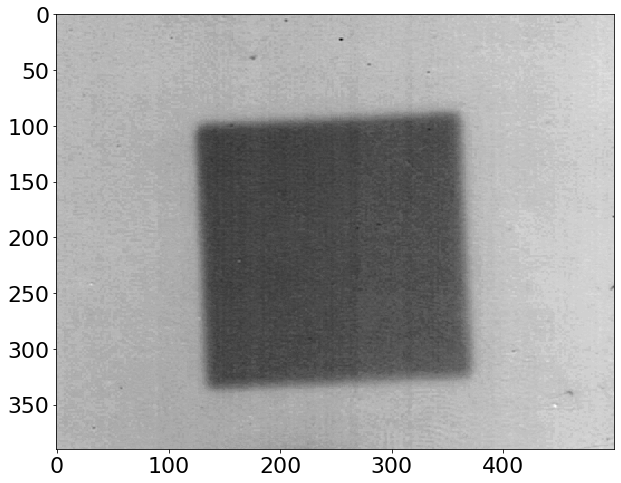

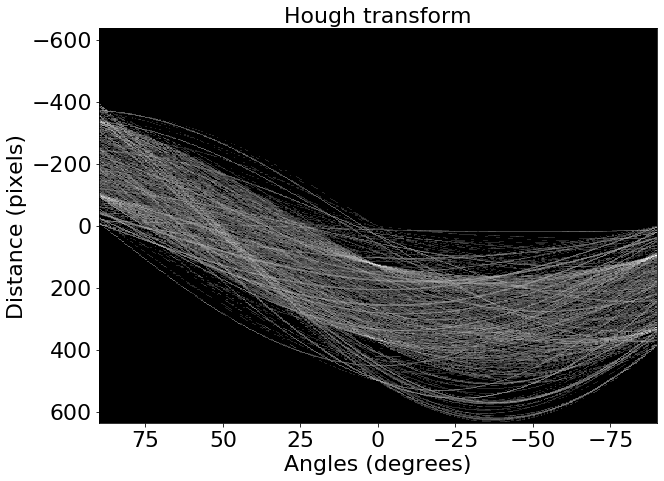

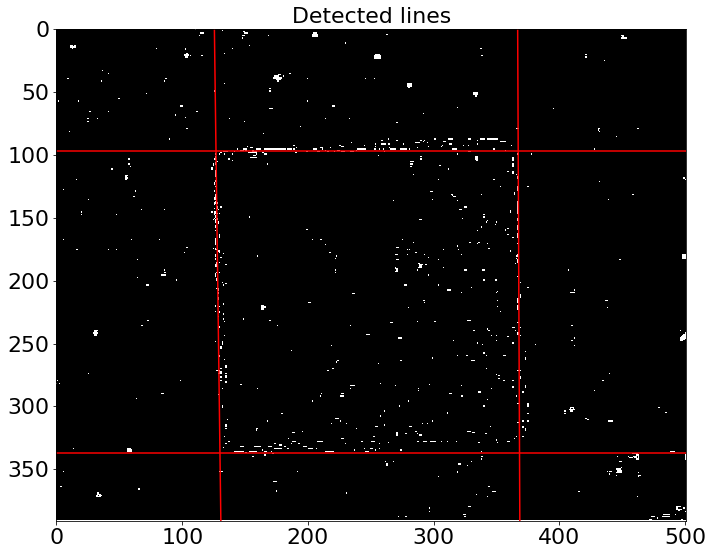

[(367, 126, 368, 130), (96, 96, 336, 336)]


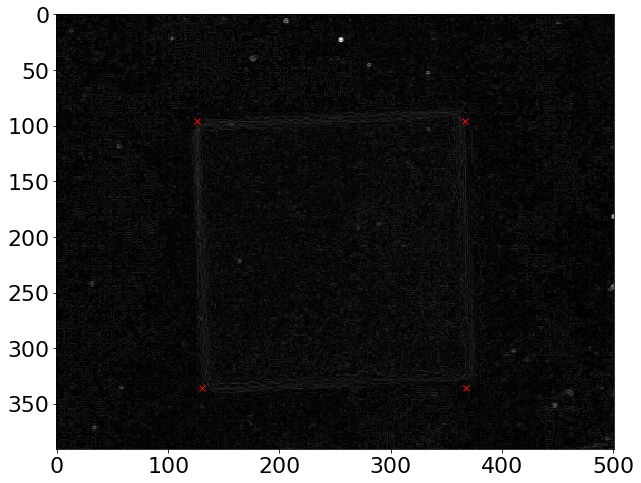

In [210]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import feature
import scipy
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import least_squares
import cv2
import tifffile as tiff
import os
from scipy import signal
import time
from scipy.optimize import minimize
from scipy.stats import norm
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from matplotlib import cm

filename = 'Calib_10days/Calibration_10days_'
params = {'legend.fontsize': '22',
          'figure.figsize': (10, 8),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'22',
         'ytick.labelsize':'22'}
plt.rcParams.update(params)
path, dirs, files = next(os.walk('Calib_10days/'))
file_count = np.arange(0,len(files),1)
numbers = ([1,2,3,4,5,6,8,10])
#doses = np.array([numbers, *[*zip(*[pixel_val(image_ret(i)) for i in numbers])]])

def pv(x,pv_min,pv_max,b,d_0): return (pv_min + (pv_max-pv_min))/((1+10**(-1*b*(np.log(d_0)-np.log(x))))) 
#def image_ret(file_num): return tiff.imread(filename+str(file_num)+'.tiff')

def snip(image,chop=2): return np.array([l[chop:-chop-1] for l in image[chop:-chop-1]])
    #This chops L R U D chop number of elements
    
def image_ret(file_num, col=0):
    full_img = tiff.imread(filename+str(file_num)+'.tiff')[:,:,col]
    return snip(full_img)

def pixel_val(image):
    roi = ([2,400],[2,500])
    x = image[:,:,0].mean(axis=0)[roi[0][0]:roi[0][1]]
    y = image[:,:,0].mean(axis=1)[roi[1][0]:roi[1][1]]
    max_x = np.argmax(np.gradient(x))
    min_x = np.argmin(np.gradient(x))
    max_y = np.argmax(np.gradient(y))
    min_y = np.argmin(np.gradient(y))
    bckgr = image[:,:,0][:min_x,max_x:][:min_y,max_y:]
    inner = image[:,:,0][min_x:max_x][min_y:max_y]
    in_avg = np.mean(inner)
    in_std = np.std(inner)/np.sqrt(len(inner))
    bckgr_avg = np.mean(bckgr)
    bckgr_std = np.std(bckgr)
    return ([in_avg,in_std,bckgr_avg,bckgr_std])

#############################
# These are filters:

def sobel(image, chop=3):
    Gx = signal.convolve(np.array([[-1,0,+1],[-2,0,+2],[-1,0,+1]]),image)
    Gy = signal.convolve(np.array([[-1,-2,-1],[0,0,0],[+1,+2,+1]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)


def prewitt(image):
    Gx = signal.convolve(np.array([[1,1,1],[0,0,0],[-1,-1,-1]]),image)
    Gy = signal.convolve(np.array([[-1,0,1],[-1,0,1],[-1,0,1]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)

def roberts(image):
    Gx = signal.convolve(np.array([[1,0],[0,-1]]),image)
    Gy = signal.convolve(np.array([[0,1],[-1,0]]),image)
    G = np.sqrt(Gx**2+Gy**2)
    return snip(G)
    
def canny(image):return snip(feature.canny(image,sigma=20))

##############################
def peak_find(array):
    i,peak_num = 1,3
    while peak_num!=2:
        peak_num = len(scipy.signal.argrelextrema(array, np.greater,order=i)[0])
        i+=round((peak_num/i)+1)
    return scipy.signal.argrelextrema(array, np.greater,order=i)[0]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

    
a = image_ret(1)


#h = Hough transform accumulator
#theta = Angles at which the transform is computed, in radians. Assumed to be continuous (angles[-1] - angles[0] == PI).
#d = Distances returned by the hough_line function.
#r<R => where R is the 
#need r>0

    
def line_eqn(line): 
    x0,x1,y0,y1 = line
    m = (y1-y0)/(x1-x0)
    c = y0
    return [m,c]


def find_intercept(line1, line2):
    m1,c1 = line1
    m2,c2 = line2
    x = (c1-c2) / (m2-m1)
    y = m1 * x + c1
    return [x,y]


def hough_grid(image,base_thresh=0,thresh_step=0.5):
    thresh = base_thresh
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
    base_image = roberts(image)
    image = np.where(base_image>thresh,1,0)
    h, theta, d = hough_line(image, theta=tested_angles)
    num_lines = len(hough_line_peaks(h, theta, d)[0])
    while num_lines != 4:
        if num_lines == 0:
            raise Exception("Could not find 4 lines in image")
        thresh += thresh_step
        image = np.where(base_image>thresh,1,0)
        h, theta, d = hough_line(image, theta=tested_angles)
        num_lines = len(hough_line_peaks(h, theta, d)[0])
    plt.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray,aspect=1/10)
    plt.title('Hough transform')
    plt.xlabel('Angles (degrees)')
    plt.ylabel('Distance (pixels)')
    plt.show()
    plt.imshow(image, cmap=cm.gray)
    origin = np.array((0, image.shape[1]))
    lines = ([])
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        plt.plot(origin, (y0, y1), '-r')
        lines.append(line_eqn([origin[0],origin[1],y0,y1]))
    plt.xlim(origin)
    plt.ylim((image.shape[0],0))
    plt.title('Detected lines')
    plt.tight_layout()
    plt.show()
    return lines
    
plt.imshow(snip(a),cm.gray)
plt.show()


lines = hough_grid(a)
#print(g)
def cross_points(image,lines):
    #takes lines and works out where they cross 
    #returns list of [x1,y1], [x2,y2]... of where points are
    done_list =([])
    roi_vals = ([])
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i!=j and not any(point in done_list for point in [[i, j], [j, i]]):
                done_list.append([i,j])
                p1,p2 = find_intercept(lines[i],lines[j])
                if 0<p1<image.shape[0] and 0<p2<image.shape[1]:
                    roi_vals.append([int(p1),int(p2)])
    return roi_vals
            
print([*zip(*cross_points(snip(a),lines))])
plt.imshow(roberts(a),cm.gray)
plt.plot(*zip(*cross_points(snip(a),lines)),'rx')
plt.show()



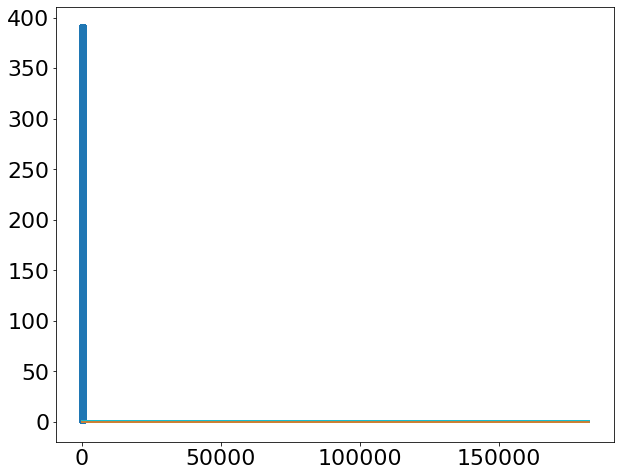

In [4]:
def find_bckgr(image):
    bckgr_l=([])
    bckgr_r=([])
    image = image[2:400,2:510]
    k = np.arange(image.shape[0])
    l = np.arange(image.shape[1])
    
    for j in l:
        for i in k:
            if image[i,j]==0:
                bckgr_l.append(tuple([i+2,j+2]))
            elif image[i,j]==1:
                j+=1
                
    for j in l[::-1]:
        for i in k[::-1]:
            if image[i,j]==0:
                bckgr_r.append(tuple([i+2,j+2]))
            elif image[i,j]==1:
                j-=1
    bckgr = ([])
    bckgr = np.array(tuple(set(bckgr_r)|set(bckgr_l)))
    bckgr = np.array([[bckgr[i][0] for i in range(len(bckgr))],[bckgr[i][1] for i in range(len(bckgr))]])
    return bckgr
bckgr = find_bckgr(G)
plt.scatter(bckgr[1],bckgr[0],marker='o')
plt.plot(G[bckgr[0]][bckgr[1]])
plt.show()

In [5]:
xscan = 200
yscan = 200
expected=(120,2,5000,200,1,25000)
params,cov=curve_fit(bimodal,x,y,expected)
plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.hist(H,bins=500)
plt.show()
#plt.plot(S[2,2:500])
#plt.plot(S[200,2:500])
#plt.show()
peak = peak_find(S[xscan,2:500])
peak1 = peak_find(S[2:400,yscan])
plt.title('Prewitt filtered image')
plt.axhline(yscan,0,a.shape[1],color='r')
plt.axvline(xscan,0,a.shape[0],color='g')
plt.plot(peak,[yscan,yscan],'bx',markersize=20,label='peak positions')
plt.plot([xscan,xscan],peak1,'bx',markersize=20,label='peak positions')
plt.imshow(S,cmap='gray')

plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()
plt.xlabel('y axis')
plt.ylabel('Pixel Value')
plt.plot(S[2:400,xscan],'g.')
plt.plot(peak1,S[peak1,yscan],'bx',markersize=20,label='peak positions')
plt.legend()
plt.show()

plt.xlabel('x axis')
plt.ylabel('Pixel Value')
plt.plot(S[yscan,2:500],'r.')
plt.plot(peak,S[xscan,peak],'bx',markersize=20,label='peak positions')
plt.legend()
plt.show()



NameError: name 'x' is not defined